In [1]:
from qcg.generators import gen_supremacy, gen_hwea
from helper_fun import evaluate_circ, get_evaluator_info, cross_entropy
from qiskit import Aer, IBMQ, execute
from time import time
import numpy as np
from qiskit.circuit.quantumregister import QuantumRegister
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,CompleteMeasFitter, TensoredMeasFitter)
from qiskit.compiler import transpile, assemble
import matplotlib.pyplot as plt

device_name = 'ibmq_boeblingen'
circ = gen_supremacy(4,4,8)

ground_truth = evaluate_circ(circ=circ,backend='statevector_simulator',evaluator_info=None)

evaluator_info = get_evaluator_info(circ=circ,device_name=device_name,fields=['num_shots'])
print('evaluator fields:',evaluator_info.keys(),'Saturated = %.3e shots'%evaluator_info['num_shots'])
qasm_noiseless_fc = evaluate_circ(circ=circ,backend='noiseless_qasm_simulator',evaluator_info=evaluator_info)

Generating 4x4, 1+8+1 supremacy circuit
current diff: 0.5265410770779029 current shots: 50176
current diff: 0.2662087799205504 current shots: 101376
current diff: 0.16831103410069964 current shots: 152576
current diff: 0.1203741026291707 current shots: 203776
evaluator fields: dict_keys(['num_shots']) Saturated = 2.365e+05 shots


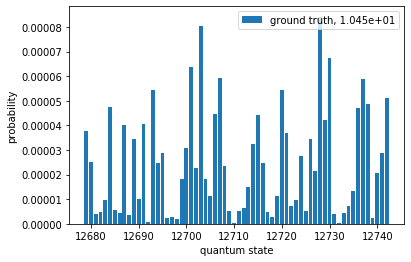

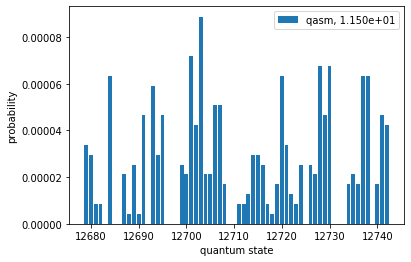

In [3]:
arbitrary_start = 12679
plot_range = min(64,len(ground_truth))
x = np.arange(len(ground_truth))[arbitrary_start:arbitrary_start+plot_range]

plt.figure()
plt.bar(x,height=ground_truth[arbitrary_start:arbitrary_start+plot_range],label='ground truth, %.3e'%cross_entropy(ground_truth,ground_truth))
plt.xlabel('quantum state')
plt.ylabel('probability')
plt.legend()
plt.show()

# plt.figure()
# plt.bar(x,height=hw[:plot_range],label='hardware, %.3e'%cross_entropy(ground_truth,hw))
# plt.xlabel('quantum state')
# plt.ylabel('probability')
# plt.legend()
# plt.show()

plt.figure()
plt.bar(x,height=qasm_noiseless_fc[arbitrary_start:arbitrary_start+plot_range],label='qasm, %.3e'%cross_entropy(ground_truth,qasm_noiseless_fc))
plt.xlabel('quantum state')
plt.ylabel('probability')
plt.legend()
plt.show()